**_NOTE_**: This homework will be hard to debug.  Make sure you start early and ask questions when you get stuck.  

# Homework 3: CUDA Conway



<img alt="Animated GIF of the conway game of life simulation running" src="https://upload.wikimedia.org/wikipedia/commons/e/e5/Gospers_glider_gun.gif" width="50%">

[Glider Generator Example from Wikipedia](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life)

> The Game of Life, also known simply as Life, is a cellular automaton devised by the British mathematician John Horton Conway in 1970.
> 
> The game is a zero-player game, meaning that its evolution is determined by its initial state, requiring no further input. One interacts with the Game of Life by creating an initial configuration and observing how it evolves, or, for advanced players, by creating patterns with particular properties.
> 
> The universe of the Game of Life is an infinite, two-dimensional orthogonal grid of square cells, each of which is in one of two possible states, alive or dead, (or populated and unpopulated, respectively). Every cell interacts with its eight neighbours, which are the cells that are horizontally, vertically, or diagonally adjacent. At each step in time, the following transitions occur:
> 
> - Any live cell with fewer than two (<2) live neighbours dies, as if by underpopulation.
> - Any live cell with two or three [2-3) live neighbours lives on to the next generation.
> - Any live cell with more than three (>3) live neighbours dies, as if by overpopulation.
> - Any dead cell with exactly three (3) live neighbours becomes a live cell, as if by reproduction.
> 
> The initial pattern constitutes the seed of the system. The first generation is created by applying the above rules simultaneously to every cell in the seed; births and deaths occur simultaneously, and the discrete moment at which this happens is sometimes called a tick. Each generation is a pure function of the preceding one. The rules continue to be applied repeatedly to create further generations.

The game of life is used as a model in a number of different scientific domains.  The following code is an OpenMP implamentation of Conway's Game of life. This example comes from here: http://ernie55ernie.github.io/parallel%20programming/2016/03/25/openmp-game-of-life.html

In this assignment, you are going to modify and improve the processing speed of Conway's Game of Life program using CUDA. 

&#9989; **<font color=red>DO THIS:</font>** Download the assignment zip folder to your HPCC account and make sure you can compile and run the software.  
    
1. Download the zip folder from D2L.
2. Change to the repository directory on a development node and run the following commands to verify the code is working:
```bash
make clean
make
make test
```
3. To complete this assignment submit all of your homework files in a zip folder to D2L.  
 


### Goals for this assignment:

By the end of this assignment, you should be able to:

* Debug and benchmark existing workflow serially.
* Update an example to compile with CUDA and run on a GPU. 

# Homework Assignment

For this assignment you will do the following parts:

1. [Establish CPU Benchmark](#Establish-CPU-Benchmark)
2. [Cudify the code.](#Cudify-the-code.)
3. [Establish CUDA Benchmarks](#Establish-CUDA-Benchmarks)
4. [ Final Report](#-Final-Report)
5. [Deliverables](#Deliverables)





---
<a name=Establish-CPU-Benchmark></a>
# 1. Establish CPU Benchmark



&#9989; **<font color=red>DO THIS:</font>** Benchmark the code provided using the "random" setting by using the following command:

    time echo "0 100" | ./gol

Where the zero for the first option specifies the random benchmark and the 100 is the number of iterations to test. Adjust the number of iterations to something that makes sense.  Make sure you record the number of iterations and the name of the  node for which you ran the tests.  Graph the results. 

You can also use the code by passing in a data file representing the start state of the system:

    time ./gol < data.txt
    
    
The repository also includes a python file which generates some "interesting" Game of Life objects.  You can use the "pipe" option to export the output of the python code into the Game of Life code using the following command:

    python board_generator.py | ./gol
    
The "Conways_game_of_life.ipynb" notebook has some examples of generating interesting objects. 

Practice using all of the above input options to make sure you understand how the code works.
    


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


([<matplotlib.axis.XTick at 0x122e7fc70>,
 [Text(5, 0, '5'),
  Text(10, 0, '10'),
  Text(15, 0, '15'),
  Text(20, 0, '20'),
  Text(25, 0, '25')])

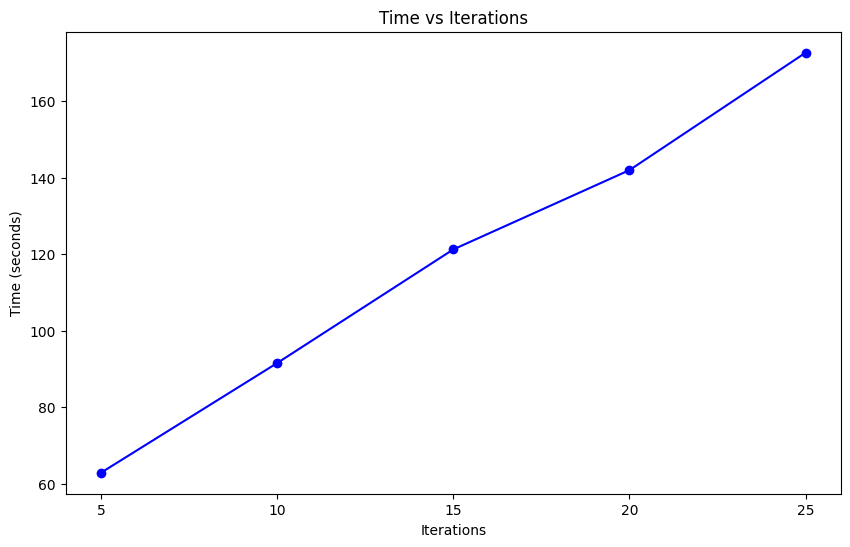

In [3]:
iterations = [5,10,15,20,25]
times = np.array([62.92,91.569,121.26,141.977,172.66])

plt.figure(figsize=(10, 6))
plt.plot(iterations, times, marker='o', linestyle='-', color='b')
plt.title('Time vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Time (seconds)')
plt.xticks(iterations)

time ./gol < data.txt : 0.011s

The following times are measured from using the -O3 flag to compile the code. 

([<matplotlib.axis.XTick at 0x122efccd0>,
 [Text(5, 0, '5'),
  Text(10, 0, '10'),
  Text(15, 0, '15'),
  Text(20, 0, '20'),
  Text(25, 0, '25')])

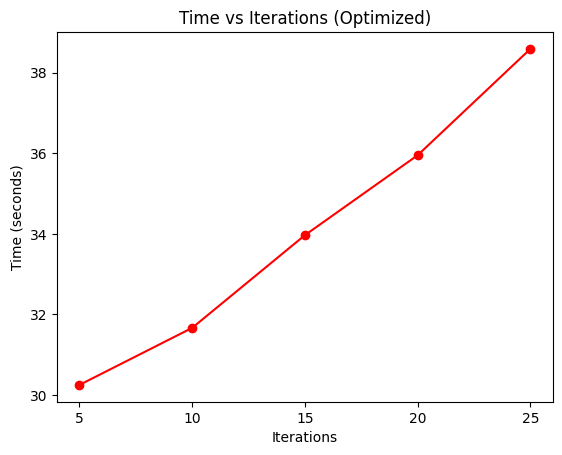

In [5]:
times_optimized = np.array([30.252,31.667,33.966,35.949,38.586])
plt.plot(iterations, times_optimized, marker='o', linestyle='-', color='r')
plt.title('Time vs Iterations (Optimized)')
plt.xlabel('Iterations')
plt.ylabel('Time (seconds)')
plt.xticks(iterations)

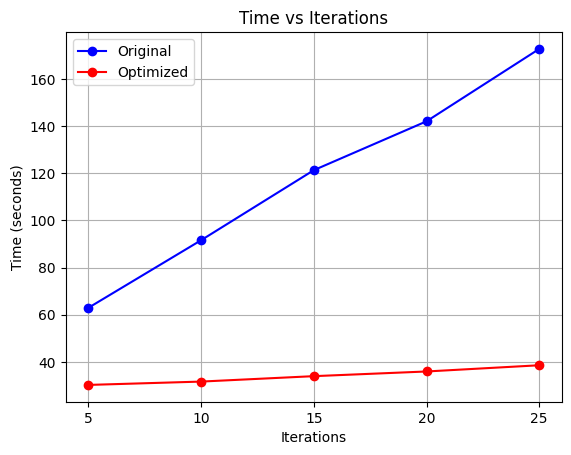

In [6]:
# combined plots
plt.plot(iterations, times, marker='o', linestyle='-', color='b', label='Original')
plt.plot(iterations, times_optimized, marker='o', linestyle='-', color='r', label='Optimized')
plt.title('Time vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Time (seconds)')
plt.xticks(iterations)
plt.legend()
plt.grid(True)



---
<a name=Cudify-the-code.></a>
# 2. Cudify the code.



&#9989; **<font color=red>DO THIS:</font>** First, update the makefile to use the cuda libraries:

1. Log onto a CUDA dev node and load the compilers using ```module load CUDA```.
1. Copy all c source files using the cu (instead of c) extension (this is needed by nvcc).
2. Change the extension variable (EXT) from ```c``` to ```cu``` in the makefile
4. Change the compiler variable (CC) from ```gcc``` to ```nvcc``` in the makefile.

At this point you should be able to still compile and test the code in serial. We haven't actually made the code run on GPUS; we are just use the ```nvcc``` compiler instead of ```gcc```.  You should now be able to make clean, make, and make test. 

&#9989; **<font color=red>DO THIS:</font>** Next, cudify the code. Here are the basic tasks you need to complete. Note that these are recommendations and you may want to come up with a slightly different solution:

1. Allocate a memory array on the GPU that is the same size as the ```plate``` array on the cpu. 
2. Before the main loop, copy the start state of the plate over to the GPU.
3. Write a kernel that will update the state of the plate on the GPU.  It is recommended that the kernel takes three inputs; pointer to the GPU plate memory, the size of the simulation ```n```, and ```which``` plate is the current plate. 
4. The main loop should be on the CPU side and will call the CUDA kernel.  
5. After the main loop, copy the GPU memory back to the CPU. 
6. Print the final state of the plate (Also an option to save as an image). 
7. Don't forget to free up the GPU memory.

Make sure you also use the following: 

- Run all cuda memory commands inside the CUDA_CALL as we did in class.
- Capture error codes from all kernel calls as we did in class. 
- Name all pointers so it is clear which ones are on the GPU and which ones are on the CPU.
- Test final results using the random, data.txt and data2.txt


Here are yet some more hints:

- CUDA is very hard to debug.  Make sure you get started early so you have plenty of time to find any problems that may arrise. A great option is to run the code inside cuda-memcheck (ex ```cuda-memcheck ./gol < data.txt```).
- There are lots of correct answers for this homework.  The instructor highly recommends that you keep things as simple as possible.  Overly complex code is much harder to debug. 
- Your instructor leaves it up to the student as to using 1D or 2D CUDA kernels. However, when you pick, please pay attention to the previous bullet.


---
<a name=Establish-CUDA-Benchmarks></a>
# 3. Establish CUDA Benchmarks




&#9989; **<font color=red>DO THIS:</font>** Benchmark the CUDA version of the code.  Make sure you carefully note the types of changes you make and use proper synchronization. Also be very clear which version of the code was used in the benchmark, what input settings were used and which HPCC computer resource was used.  Plot your results in meaningful and easy to understand ways. 


---- GPU -------
time ./gol < data.txt: 0.331s
time ./gol < data2.txt: 1m4.275s

---- CPU -------
time ./gol < data.txt: 0.013s
time ./gol < data2.txt: 1m4.083s

---- CPU with O3 -------
time ./gol < data.txt: 0.012s
time ./gol < data2.txt: 1m1.624s


---- GPU ------
iterations = [5,10,15,20,25]
times_gpu = [59.431, 52.424, 47.681, 44.538, 42.024]

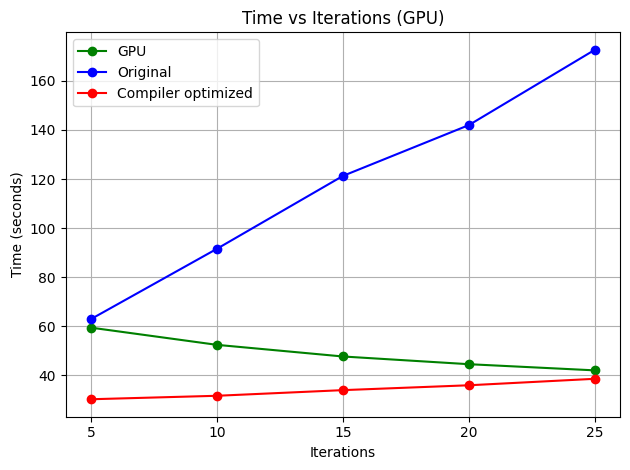

In [10]:
iterations = [5,10,15,20,25]
times_gpu = [59.431, 52.424, 47.681, 44.538, 42.024]

plt.plot(iterations, times_gpu, marker='o', linestyle='-', color='g', label='GPU')
plt.plot(iterations, times, marker='o', linestyle='-', color='b', label='Original')
plt.plot(iterations, times_optimized, marker='o', linestyle='-', color='r', label='Compiler optimized')
plt.title('Time vs Iterations (GPU)')
plt.xlabel('Iterations')
plt.ylabel('Time (seconds)')
plt.xticks(iterations)
plt.legend()
plt.grid(True)
plt.tight_layout()

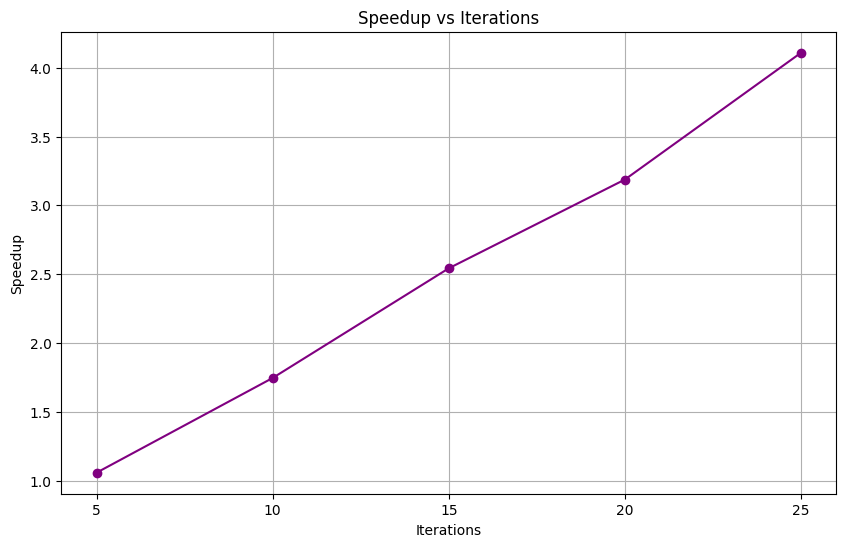

In [11]:
speedup = np.array(times) / np.array(times_gpu)
plt.figure(figsize=(10, 6))
plt.plot(iterations, speedup, marker='o', linestyle='-', color='purple')
plt.title('Speedup vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Speedup')
plt.xticks(iterations)
plt.grid(True)

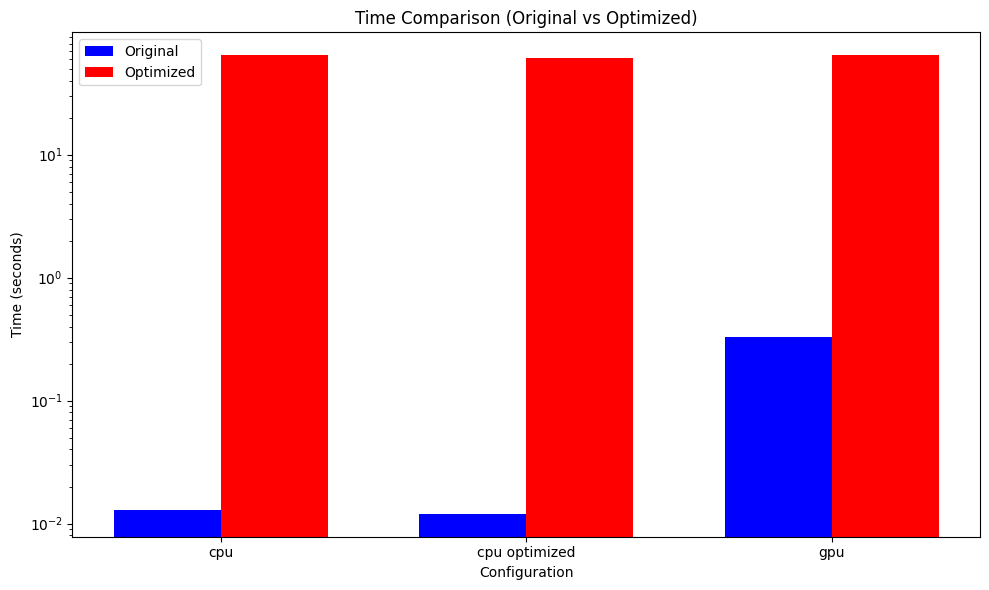

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data
xticks = ['cpu', 'cpu optimized', 'gpu']
times_data = np.array([0.013, 0.012, 0.331])  # Original times
times_data2 = np.array([64.083, 61.624, 64.275])  # Optimized times

# Positions for the bars
x = np.arange(len(xticks)) 
width = 0.35  #

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, times_data, width, color='b', label='Original')
plt.bar(x + width/2, times_data2, width, color='r', label='Optimized')
plt.title('Time Comparison (Original vs Optimized)')
plt.xlabel('Configuration')
plt.ylabel('Time (seconds)')
plt.yscale('log')  # Log scale for matching the y-axis
plt.xticks(x, xticks)  # Set x-ticks to configuration names
plt.legend()
plt.tight_layout()
plt.show()



---
<a name=-Final-Report></a>
# 4.  Final Report




&#9989; **<font color=red>DO THIS:</font>** Write a report describing what you learned.  Start by describing how the provided serial code performed and what you did to accurately measure that performance. Then, if applicable, talk about what you did to optimize the serial performance. Finally, describe what you did to add in CUDA code to make it hopefully run faster.  Make sure you include well labeled graphs of all of your benchmarking data and explain the graphs in your report text with a focus on any odd results you may see.  Conclude with a general lessons learned. A sample structure for a report has been supplied in "Report.ipynb", which can be used as inspiration for how to format your report. 

The code generates images, you should include a few in your report. 



---
<a name=Deliverables></a>
# 5. Deliverables

&#9989; **<font color=red>DO THIS:</font>** Prepare your files for the instructor.  I recommend having three versions of the code; original serial version, optimized serial version (if applicable), and optimized CUDA version.  Update the provided ```makefile``` to build all three executables. The files should include.

When you are done, upload your report and all code files to the D2L submission box. Your instructor will use the following command to compile and test your code on the HPCC:

Change the CC to gcc or nvcc depending on what you want to test. 

    make clean
    make 
    make test

-----
### Congratulations, you are done!

Submit your tgz file to the course Desire2Learn page in the HW3 assignment dropbox.  

Written by Dr. Dirk Colbry, Michigan State University (Updated by Dr. Nathan Haut in Spring 2025)
<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

----